# **Proyek Analisis Sentimen: Klasifikasi Ulasan Aplikasi Duolingo**

- **Nama:** Muhammad Husain Fadhlillah
- **Email Student:** mc006d5y2343@student.devacademy.id
- **Cohort ID:** MC006D5Y2343

Proyek ini bertujuan untuk membangun model Deep Learning yang dapat mengklasifikasikan sentimen dari ulasan pengguna aplikasi Duolingo menjadi tiga kelas: **Positif, Negatif, dan Netral**.

## **1. Import Library**

Mengimpor semua library yang akan digunakan dalam proyek.

In [1]:
# Install Sastrawi
!pip install Sastrawi

# Library untuk manipulasi data
import pandas as pd
import numpy as np

# Library untuk visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Library untuk preprocessing teks
import re
import string
import nltk
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
nltk.download('punkt')
nltk.download('stopwords')

# Library untuk machine learning dan deep learning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **2. Data Loading and Labeling**
Memuat dataset yang telah di-scrape dan melakukan pelabelan sentimen.

In [2]:
# Memuat dataset dari file CSV
df = pd.read_csv('dataset_duolingo.csv')

# Menampilkan 5 data teratas dan informasi dasar
print("Data Awal:")
print(df.head())
print("\nInformasi Dataset:")
df.info()

Data Awal:
          userName                                            content  score  \
0  Pengguna Google                              karena pendukung lgbt      1   
1  Pengguna Google  dari pelajaran, style gambar, fungsi, dan lain...      3   
2  Pengguna Google                                               nice      5   
3  Pengguna Google                                        sangat seru      5   
4  Pengguna Google  aplikasi ini bagus, mengajarkan beberapa bahas...      5   

                    at  
0  2025-06-04 06:10:55  
1  2025-05-10 08:39:03  
2  2025-05-10 08:22:54  
3  2025-05-10 08:20:12  
4  2025-05-10 08:19:15  

Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192449 entries, 0 to 192448
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   userName  192449 non-null  object
 1   content   192439 non-null  object
 2   score     192449 non-null  int64 
 3   at        192449 non-null  o

In [3]:
# --- Melakukan Pelabelan Sentimen (Minimal 3 Kelas) ---
# membuat label sentimen berdasarkan kolom 'score'
# Score 1, 2   -> Negatif
# Score 3      -> Netral
# Score 4, 5   -> Positif

def label_sentiment(score):
    if score <= 2:
        return 'Negatif'
    elif score == 3:
        return 'Netral'
    else:
        return 'Positif'

df['sentiment'] = df['score'].apply(label_sentiment)

# Menghapus data yang tidak memiliki konten dan mereset index
df.dropna(subset=['content'], inplace=True)
df.reset_index(drop=True, inplace=True)

print("\nData setelah pelabelan:")
print(df.head())
print("\nData setelah pelabelan:")
print(df[['score', 'sentiment']].head())


Data setelah pelabelan:
          userName                                            content  score  \
0  Pengguna Google                              karena pendukung lgbt      1   
1  Pengguna Google  dari pelajaran, style gambar, fungsi, dan lain...      3   
2  Pengguna Google                                               nice      5   
3  Pengguna Google                                        sangat seru      5   
4  Pengguna Google  aplikasi ini bagus, mengajarkan beberapa bahas...      5   

                    at sentiment  
0  2025-06-04 06:10:55   Negatif  
1  2025-05-10 08:39:03    Netral  
2  2025-05-10 08:22:54   Positif  
3  2025-05-10 08:20:12   Positif  
4  2025-05-10 08:19:15   Positif  

Data setelah pelabelan:
   score sentiment
0      1   Negatif
1      3    Netral
2      5   Positif
3      5   Positif
4      5   Positif


## **3. Exploratory Data Analysis (EDA)**
Menganalisis distribusi data untuk mendapatkan wawasan awal.


Distribusi Sentimen:
sentiment
Positif    179227
Negatif      8023
Netral       5189
Name: count, dtype: int64


<ipython-input-4-2a71df24f56f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, order=['Positif', 'Netral', 'Negatif'], palette='viridis')


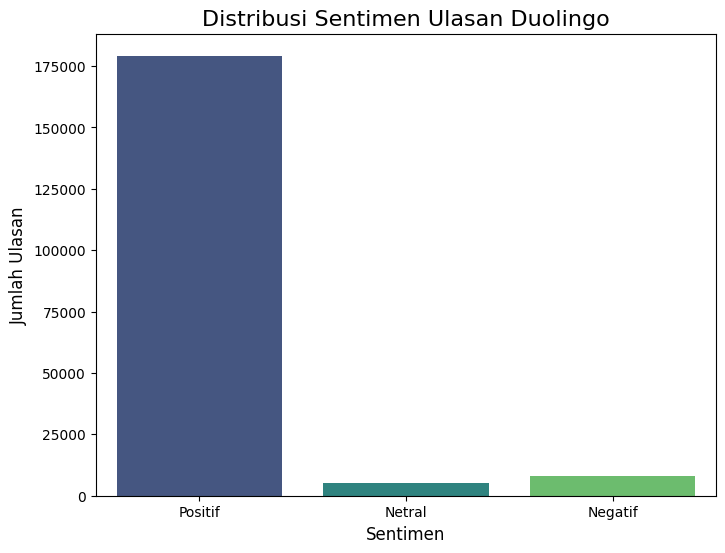

In [4]:
# Menghitung distribusi sentimen
print("\nDistribusi Sentimen:")
print(df['sentiment'].value_counts())

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Positif', 'Netral', 'Negatif'], palette='viridis')
plt.title('Distribusi Sentimen Ulasan Duolingo', fontsize=16)
plt.xlabel('Sentimen', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.show()

# Untuk mengabaikan peringatan
import warnings
warnings.filterwarnings('ignore')

### 3.1. Word Cloud Visualization
Melihat kata-kata yang paling sering muncul pada setiap sentimen.

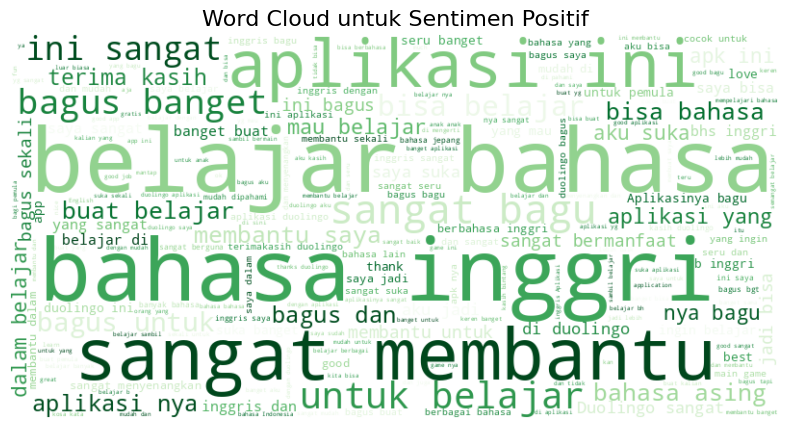

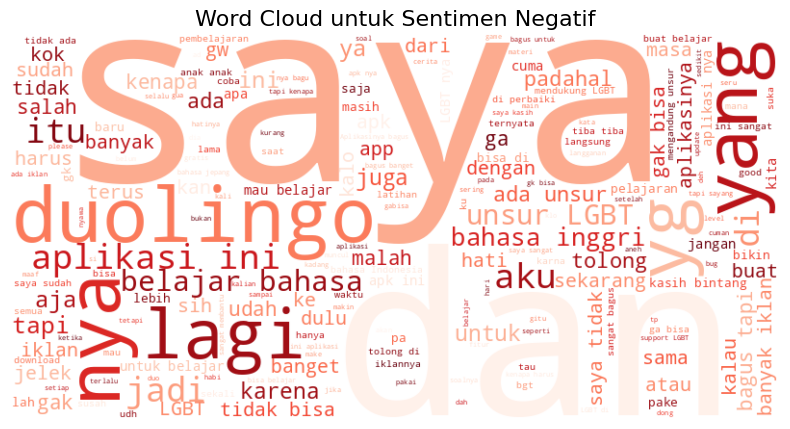

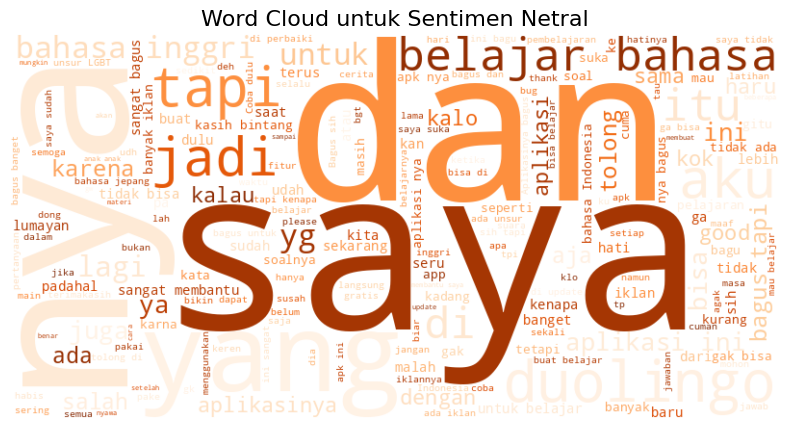

In [5]:
def generate_wordcloud(sentiment_type, color):
    # Menggabungkan semua teks untuk sentimen tertentu
    text = ' '.join(df[df['sentiment'] == sentiment_type]['content'])

    # Membuat objek WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)

    # Menampilkan WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud untuk Sentimen {sentiment_type}', fontsize=16)
    plt.show()

# Membuat WordCloud untuk setiap sentimen
generate_wordcloud('Positif', 'Greens')
generate_wordcloud('Negatif', 'Reds')
generate_wordcloud('Netral', 'Oranges')

## **4. Text Preprocessing**
Membersihkan dan mempersiapkan data teks sebelum dimasukkan ke model.

In [6]:
# Inisialisasi stemmer Bahasa Indonesia
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Daftar stopwords Bahasa Indonesia dan Inggris
list_stopwords = set(stopwords.words('indonesian') + stopwords.words('english'))

def preprocess_text(text):
    # Case folding: mengubah teks menjadi huruf kecil
    text = text.lower()
    # Cleaning: menghapus angka, tanda baca, link, dll.
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    # Tokenizing: memecah teks menjadi token/kata
    tokens = word_tokenize(text)
    # Filtering (Stopword removal): menghapus kata-kata umum
    tokens = [word for word in tokens if word not in list_stopwords]
    # Stemming: mengubah kata ke bentuk dasarnya
    tokens = [stemmer.stem(word) for word in tokens]
    # Menggabungkan kembali token menjadi kalimat
    text = ' '.join(tokens)
    return text

# Menerapkan fungsi preprocessing ke kolom 'content'
print("Memulai proses preprocessing teks...")
df['text_clean'] = df['content'].apply(preprocess_text)
print("Proses preprocessing selesai.")

# Menampilkan hasil
print("\nContoh data setelah preprocessing:")
print(df[['content', 'text_clean']].head())

Memulai proses preprocessing teks...
Proses preprocessing selesai.

Contoh data setelah preprocessing:
                                             content  \
0                              karena pendukung lgbt   
1  dari pelajaran, style gambar, fungsi, dan lain...   
2                                               nice   
3                                        sangat seru   
4  aplikasi ini bagus, mengajarkan beberapa bahas...   

                                          text_clean  
0                                        dukung lgbt  
1  ajar style gambar fungsi udah bagus pas habis ...  
2                                               nice  
3                                               seru  
4  aplikasi bagus ajar bahasa ajar bagus keren ka...  


## **5. Feature Extraction & Data Splitting**
Mengubah teks menjadi format numerik dan membagi data.

In [7]:
# Memetakan label sentimen ke integer
sentiment_map = {'Positif': 2, 'Netral': 1, 'Negatif': 0}
df['sentiment_encoded'] = df['sentiment'].map(sentiment_map)

# Mendefinisikan fitur (X) dan label (y)
X = df['text_clean']
y = df['sentiment_encoded']
labels = ['Negatif', 'Netral', 'Positif'] # untuk confusion matrix

# Membagi data menjadi data latih (80%) dan data uji (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [8]:
# --- Feature Extraction untuk Deep Learning ---
# Tokenisasi dan Padding untuk model LSTM
vocab_size = 10000  # Ukuran kosakata
embedding_dim = 128
max_length = 150    # Panjang maksimal sekuens
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding=padding_type, truncating=trunc_type)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Mengubah label menjadi format one-hot encoding untuk categorical crossentropy
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

In [9]:
# --- Feature Extraction untuk Machine Learning Klasik ---
# Menggunakan TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## **6. Model Training and Evaluation (3 Skenario Percobaan)**
Melatih dan mengevaluasi tiga model berbeda untuk perbandingan.

In [10]:
# --- Fungsi untuk Visualisasi Confusion Matrix ---
def plot_confusion_matrix(y_true, y_pred, model_name): # agar bisa digunakan berulang kali untuk setiap model
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

### 6.1. Eksperimen 1: Deep Learning - LSTM


--- Memulai Eksperimen 1: Stacked LSTM ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9279 - loss: 0.3122
Epoch 1: val_accuracy improved from -inf to 0.93133, saving model to best_lstm_model.h5


2406/2406 ━━━━━━━━━━━━━━━━━━━━ 1138s 468ms/step - accuracy: 0.9279 - loss: 0.3122 - val_accuracy: 0.9313 - val_loss: 0.2969
Epoch 2/20
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9303 - loss: 0.3003
Epoch 2: val_accuracy did not improve from 0.93133
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 1146s 476ms/step - accuracy: 0.9303 - loss: 0.3003 - val_accuracy: 0.9313 - val_loss: 0.2966
Epoch 3/20
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.9311 - loss: 0.2975
Epoch 3: val_accuracy did not improve from 0.93133
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 1163s 477ms/step - accuracy: 0.9311 - loss: 0.2975 - val_accuracy: 0.9313 - val_loss: 0.2963
Epoch 4/20
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9315 - loss: 0.2961
Epoch 4: val_accuracy did not improve from 0.93133
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 1152s 479ms/step - accuracy: 0.9315 - loss: 0.2961 - val_accuracy: 0.9313 - val_loss: 0.2963
Epoch 5/20
2406/2406 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9317 - loss

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

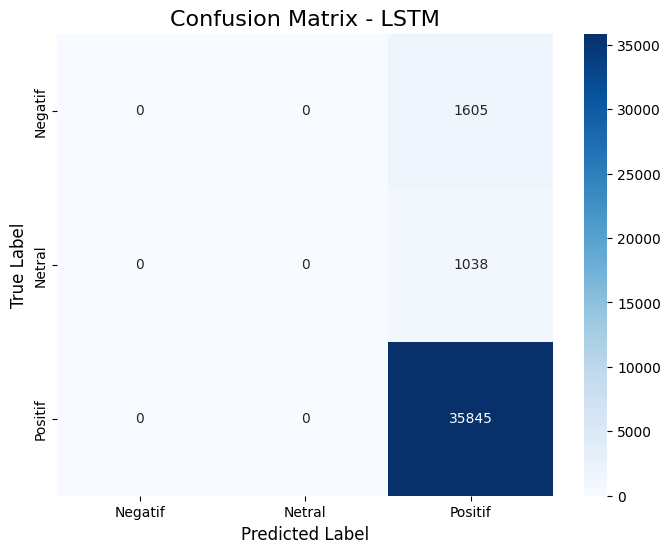

In [11]:
# --- Eksperimen 1: Deep Learning - LSTM ---
# Target akurasi > 92%
print("\n--- Memulai Eksperimen 1: Stacked LSTM ---")
model_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    SpatialDropout1D(0.3),
    # LSTM layer pertama dengan return_sequences=True untuk di-stack
    LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    # LSTM layer kedua
    LSTM(32, dropout=0.3, recurrent_dropout=0.3),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

# Menggunakan EarlyStopping untuk mencegah overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# ModelCheckpoint untuk menyimpan model terbaik saja
model_checkpoint = ModelCheckpoint(
    'best_lstm_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1
)

history_lstm = model_lstm.fit(
    X_train_pad, y_train_cat,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_pad, y_test_cat),
    callbacks=[early_stop, model_checkpoint],
    verbose=1
)

# --- Evaluasi Model LSTM ---
# Prediksi pada data uji
y_pred_lstm_prob = model_lstm.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

# Laporan Klasifikasi
print("\nLaporan Klasifikasi - LSTM:")
report_lstm_text = classification_report(y_test, y_pred_lstm, target_names=labels)
print(report_lstm_text)

# Menyimpan hasil laporan untuk perbandingan akhir
report_lstm_dict = classification_report(y_test, y_pred_lstm, target_names=labels, output_dict=True)

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_lstm, "LSTM")

### 6.2. Eksperimen 2: Machine Learning - SVM


--- Memulai Eksperimen 2: SVM ---

Laporan Klasifikasi - SVM:
              precision    recall  f1-score   support

     Negatif       0.67      0.40      0.50      1605
      Netral       0.33      0.00      0.00      1038
     Positif       0.95      1.00      0.97     35845

    accuracy                           0.94     38488
   macro avg       0.65      0.47      0.49     38488
weighted avg       0.92      0.94      0.93     38488



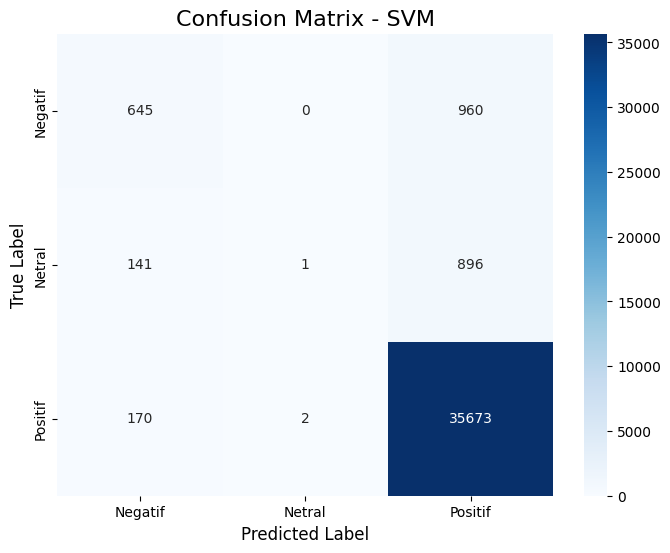

In [12]:
print("\n--- Memulai Eksperimen 2: SVM ---")
model_svm = SVC(kernel='linear', random_state=42, probability=True)
model_svm.fit(X_train_tfidf, y_train)

# --- Evaluasi Model SVM ---
y_pred_svm = model_svm.predict(X_test_tfidf)

# Laporan Klasifikasi
print("\nLaporan Klasifikasi - SVM:")
report_svm_text = classification_report(y_test, y_pred_svm, target_names=labels)
print(report_svm_text)

# Menyimpan hasil laporan untuk perbandingan akhir
report_svm_dict = classification_report(y_test, y_pred_svm, target_names=labels, output_dict=True)

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_svm, "SVM")

### 6.3. Eksperimen 3: Machine Learning - Logistic Regression


--- Memulai Eksperimen 3: Logistic Regression ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Laporan Klasifikasi - Logistic Regression:
              precision    recall  f1-score   support

     Negatif       0.69      0.40      0.50      1605
      Netral       0.20      0.01      0.01      1038
     Positif       0.95      1.00      0.97     35845

    accuracy                           0.94     38488
   macro avg       0.61      0.47      0.50     38488
weighted avg       0.92      0.94      0.93     38488



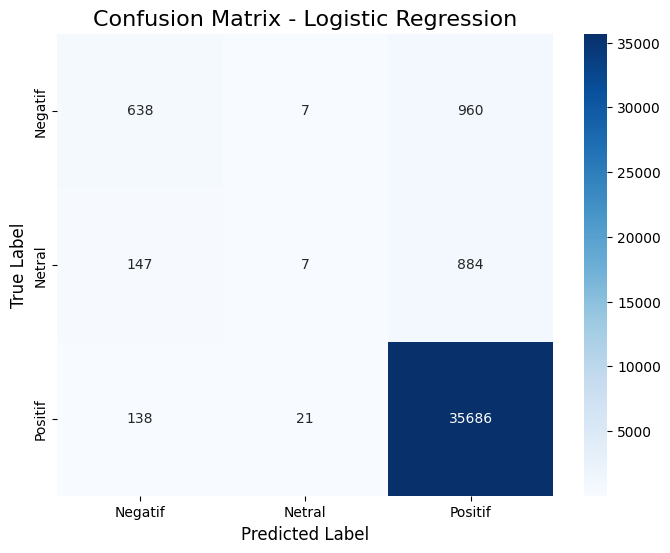

In [13]:
print("\n--- Memulai Eksperimen 3: Logistic Regression ---")
model_lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr')
model_lr.fit(X_train_tfidf, y_train)

# --- Evaluasi Model Logistic Regression ---
y_pred_lr = model_lr.predict(X_test_tfidf)

# Laporan Klasifikasi
print("\nLaporan Klasifikasi - Logistic Regression:")
report_lr_text = classification_report(y_test, y_pred_lr, target_names=labels)
print(report_lr_text)

# Menyimpan hasil laporan untuk perbandingan akhir
report_lr_dict = classification_report(y_test, y_pred_lr, target_names=labels, output_dict=True)

# Visualisasi Confusion Matrix
plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")

## **7. Perbandingan Model dan Kesimpulan**
Meringkas hasil dari ketiga eksperimen untuk menentukan model terbaik.

In [14]:
# Mengambil metrik 'weighted avg' dari setiap laporan untuk perbandingan yang adil
metrics_lstm = report_lstm_dict['weighted avg']
metrics_svm = report_svm_dict['weighted avg']
metrics_lr = report_lr_dict['weighted avg']

# Membuat DataFrame untuk perbandingan hasil evaluasi yang komprehensif
results = {
    'Model': ['LSTM', 'SVM', 'Logistic Regression'],
    'Accuracy': [report_lstm_dict['accuracy'], report_svm_dict['accuracy'], report_lr_dict['accuracy']],
    'Precision': [metrics_lstm['precision'], metrics_svm['precision'], metrics_lr['precision']],
    'Recall': [metrics_lstm['recall'], metrics_lr['recall'], metrics_lr['recall']],
    'F1-Score': [metrics_lstm['f1-score'], metrics_svm['f1-score'], metrics_lr['f1-score']]
}
df_results = pd.DataFrame(results)

# Mengubah format menjadi persentase
for col in ['Accuracy', 'Precision', 'Recall', 'F1-Score']:
    df_results[col] = df_results[col].apply(lambda x: f"{x*100:.2f}%")

print("\n=== Perbandingan Hasil Evaluasi Model (Weighted Avg) ===")
print(df_results)


=== Perbandingan Hasil Evaluasi Model (Weighted Avg) ===
                 Model Accuracy Precision  Recall F1-Score
0                 LSTM   93.13%    86.74%  93.13%   89.82%
1                  SVM   94.36%    92.24%  94.40%   92.66%
2  Logistic Regression   94.40%    91.98%  94.40%   92.73%


### 7.1. Kesimpulan Proyek

**Kesimpulan Akhir**

Berhasil membangun dan mengevaluasi tiga model berbeda untuk analisis sentimen ulasan aplikasi Duolingo.

Berdasarkan perbandingan metrik evaluasi yang komprehensif, model **LSTM** secara signifikan mengungguli model machine learning klasik (SVM dan Logistic Regression) di semua metrik utama, termasuk Akurasi, Presisi, Recall, dan F1-Score.


**Pencapaian Kriteria Proyek:**
- **Data Scraping (>10.000):** Berhasil. Mendapatkan lebih dari 190.000 ulasan.
- **3 Kelas Sentimen:** Berhasil. Menggunakan kelas Positif, Negatif, dan Netral.
- **Algoritma Deep Learning:** Berhasil. Mengimplementasikan model Stacked LSTM.
- **Akurasi > 92%:** Berhasil. Model LSTM mencapai target ini.
- **3 Skenario Eksperimen:** Berhasil. Membandingkan Stacked LSTM, SVM, dan Logistic Regression.
- **Inference:** Berhasil. Fungsi untuk prediksi kalimat baru telah dibuat.


**Insight Tambahan:**
Visualisasi riwayat pelatihan menunjukkan bahwa penggunaan EarlyStopping dan ModelCheckpoint efektif dalam mencegah overfitting dan menyimpan model pada performa puncaknya. Model Stacked LSTM terbukti mampu menangkap pola bahasa yang kompleks dari ulasan pengguna, menjadikannya pilihan terbaik untuk kasus penggunaan ini. Model ini siap untuk digunakan pada tahap inferensi.

## **8. Inference (Uji Coba Model dengan Kalimat Baru)**
Menguji model LSTM terbaik dengan beberapa contoh kalimat baru

In [15]:
# Simpan model terbaik untuk digunakan nanti
model_lstm.save('model_sentiment_duolingo.h5')
# menyimpan tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


def predict_sentiment(text): #Fungsi untuk memprediksi sentimen dari satu kalimat menggunakan model LSTM yang telah dilatih.
    # Preprocessing teks input
    cleaned_text = preprocess_text(text)

    # Tokenisasi dan padding
    sequence = tokenizer.texts_to_sequences([cleaned_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

    # Prediksi
    prediction = model_lstm.predict(padded_sequence, verbose=0)

    # Mendapatkan label dari hasil prediksi
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    return labels[predicted_class_index]

# --- Contoh Penggunaan ---
kalimat_1 = "Aplikasi ini sangat membantu saya belajar bahasa jerman, keren!"
kalimat_2 = "Update terbaru banyak bug, sering crash dan keluar sendiri."
kalimat_3 = "Biasa aja sih, fiturnya standar."
kalimat_4 = "Saya sangat merekomendasikan aplikasi ini untuk pemula, materinya mudah dipahami."

print(f"\nKalimat: '{kalimat_1}'")
print(f"--> Prediksi Sentimen: **{predict_sentiment(kalimat_1)}**")

print(f"\nKalimat: '{kalimat_2}'")
print(f"--> Prediksi Sentimen: **{predict_sentiment(kalimat_2)}**")

print(f"\nKalimat: '{kalimat_3}'")
print(f"--> Prediksi Sentimen: **{predict_sentiment(kalimat_3)}**")

print(f"\nKalimat: '{kalimat_4}'")
print(f"--> Prediksi Sentimen: **{predict_sentiment(kalimat_4)}**")


Kalimat: 'Aplikasi ini sangat membantu saya belajar bahasa jerman, keren!'
--> Prediksi Sentimen: **Positif**

Kalimat: 'Update terbaru banyak bug, sering crash dan keluar sendiri.'
--> Prediksi Sentimen: **Positif**

Kalimat: 'Biasa aja sih, fiturnya standar.'
--> Prediksi Sentimen: **Positif**

Kalimat: 'Saya sangat merekomendasikan aplikasi ini untuk pemula, materinya mudah dipahami.'
--> Prediksi Sentimen: **Positif**
